In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor


In [2]:
torch.__version__

'2.8.0+cu129'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_data = torchvision.datasets.CIFAR100('./cifar100/', download=True, train=True, transform=ToTensor())
test_data = torchvision.datasets.CIFAR100('./cifar100/', download=True, train=False, transform=ToTensor())


100.0%


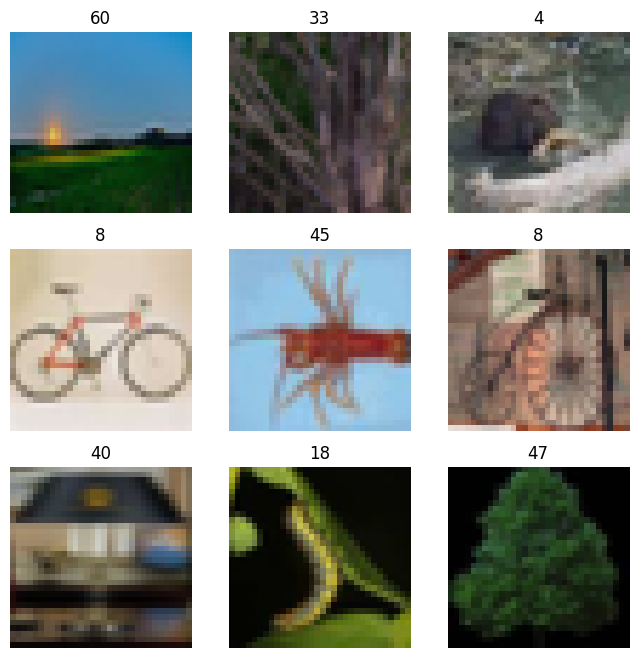

In [5]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(torch.einsum("c h w -> h w c", img))

plt.show()

capsicom!

In [6]:
# patch dims = P * P
P = 16

C, H, W = train_data[0][0].shape
N = H * W // P**2

print(f"{N} patches with height width {P} x {P}")

4 patches with height width 16 x 16


In [7]:
x = torch.arange(16)
x = x.view(1, 1, 4, 4)
x

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

In [8]:
x.unfold(2,2,2).unfold(3,2,2)

tensor([[[[[[ 0,  1],
            [ 4,  5]],

           [[ 2,  3],
            [ 6,  7]]],


          [[[ 8,  9],
            [12, 13]],

           [[10, 11],
            [14, 15]]]]]])

In [9]:
x.unfold(2,2,2).unfold(3, 2, 2).reshape(1,1,-1,2,2)

tensor([[[[[ 0,  1],
           [ 4,  5]],

          [[ 2,  3],
           [ 6,  7]],

          [[ 8,  9],
           [12, 13]],

          [[10, 11],
           [14, 15]]]]])

In [10]:
def create_patches(imgs, P):

    # imgs is of shape (B, C, H, W)
    # gotta convert to (B, N, C, P, P)

    B, C, H, W = imgs.shape

    # take patches of size P along the rows
    imgs = imgs.unfold(2, P, P)
    # rearrange to "transpose" the pixels into correct order
    imgs = imgs.unfold(3, P, P)

    imgs = torch.einsum("b c a d h w -> b a d c h w",imgs)
    imgs = imgs.reshape(B,-1, C, P, P)

    return imgs

In [11]:
sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]
img = img.view(1, *img.shape)
print(img.shape)

patches = create_patches(img, P)
# 16 patches of 8x8
patches[0].shape

torch.Size([1, 3, 32, 32])


torch.Size([4, 3, 16, 16])

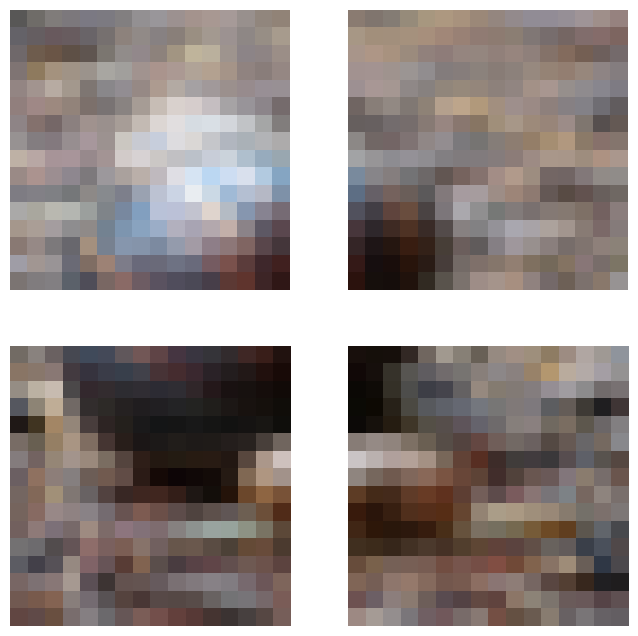

In [12]:
figure = plt.figure(figsize=(8,8))
cols, rows = N//2, N//2
for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(torch.einsum("c h w -> h w c", patches[0][i]))

plt.show()

In [13]:
block_size = N + 1

In [14]:
class Attn(nn.Module):

    def __init__(self,n_embd, head_size):
        super().__init__()

        self.Q = nn.Linear(n_embd, head_size)
        self.K = nn.Linear(n_embd, head_size)
        self.V = nn.Linear(n_embd, head_size)
        self.head_size = head_size
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # dim = (B, T, n_embd) -> (B, T, head_size)
        queries = self.Q(x)
        keys = self.K(x)
        values = self.V(x)

        # need (B, T, T)
        # affinity of token at each time step
        # (B, T, head_size) * (B, head_size, T) -> (B, T, T)
        weights = (queries @ torch.einsum("b t h -> b h t", keys)) / self.head_size**0.5

        weights = F.softmax(weights, dim=-1)

        # (B, T, T) * (B, T, head_size) = (B, T, head_size)
        x = weights @ values

        return x

In [15]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Attn(n_embd=n_embd, head_size=head_size).to(device) for _ in range(num_heads)])

        self.linear = nn.Linear(n_embd, n_embd)

    def forward(self, x):

        activations = [head(x) for head in self.heads]

        x = self.linear(torch.concat(activations, dim=-1))

        return x

In [16]:
class MLP(nn.Module):

    def __init__(self, in_features, hidden_size, out_features, bias=False):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_size, bias=bias)
        self.linear2 = nn.Linear(hidden_size, out_features, bias=bias)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.linear2(self.relu(self.linear1(x)))

        # im not kidding i forgot this statement and then proceeded to lose my fucking mind
        return x


In [17]:
class Transformer(nn.Module):
    def __init__(self, n_embd, num_heads, head_size, hidden_size):
        super().__init__()

        self.LN = nn.LayerNorm(n_embd)

        self.MHA = MultiHeadAttention(num_heads, n_embd, head_size)

        self.MLP = MLP(n_embd, hidden_size, n_embd)

    def forward(self, x):
        x = self.LN(x)

        x = self.LN(self.MHA(x) + x)

        x = self.MLP(x) + x

        return x

In [18]:
num_heads = 32
hidden_size = 1024
D = 512
head_size = D // num_heads
P = 16
n_blocks = 6

In [40]:
class VIT(nn.Module):

    def __init__(self, n_categories, n_embd, num_heads, head_size, hidden_size, bias=True):

        super().__init__()
        self.E = nn.Linear(P**2 * C, D)
        self.E_pos = nn.Embedding(num_embeddings=N+1, embedding_dim=n_embd)
        self.cls_token = nn.Parameter(torch.randn(1, 1, n_embd))

        self.transformer_blocks = nn.Sequential(*[Transformer(n_embd, num_heads, head_size, hidden_size).to(device) for _ in range(n_blocks)])

        # self.LN = nn.LayerNorm(n_embd)

        # self.MHA = MultiHeadAttention(num_heads, n_embd, head_size).to(device)

        # self.MLP = MLP(n_embd, hidden_size, n_embd, bias).to(device)

        self.catMLP = MLP(n_embd, hidden_size, n_categories, bias).to(device)

    def forward(self, x, targets=None):

        B, C, H, W = x.shape

        patches = create_patches(x, P)
        patches = patches.view(*patches.shape[:-3], -1)

        B, N, P_2_C = patches.shape
        embeddings = self.E(patches)

        # merge the 0th embedding on the time dimension
        # print(embeddings.shape)
        # print(self.cls_token.shape)
        pos_embd = self.E_pos(torch.arange(N+1, device=device))
        tok_embd = torch.cat([self.cls_token.expand(B, 1, -1), embeddings], dim=1)
        final_embd = tok_embd + pos_embd

        # final_embd = self.LN(final_embd)

        # attn = self.LN(self.MHA(final_embd) + final_embd)

        # act = self.MLP(attn) + attn

        act = self.transformer_blocks(final_embd)

        # print(act)
        # print(act.shape)

        first_embd = act[:, 0, :]
        # print(first_embd)
        # print(first_embd.shape)

        logits = self.catMLP(first_embd)

        if targets == None:
                    loss = None
        else:
            targets = targets.view(-1)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def predict(self, x, k=1):

        logits, loss = self(x)

        probs = F.softmax(logits, dim=1)

        top_k = torch.multinomial(probs, num_samples=k)

        return top_k


In [20]:
model = VIT(100, D, num_heads, head_size, hidden_size).to(device)

In [21]:
logits, loss = model(img.to(device), torch.tensor(label, device=device))
print(logits)

tensor([[-2.2582e-01, -2.4958e-01,  2.4507e-01,  1.4870e-01, -5.0207e-01,
          4.1114e-02,  2.2847e-01, -5.7594e-01, -1.1240e-01,  3.3662e-01,
         -4.5371e-02,  1.8830e-01,  6.6457e-03,  2.8079e-01, -2.7714e-01,
          1.3943e-01, -1.2377e-01,  3.0713e-01, -6.0731e-02,  5.7927e-02,
         -3.4758e-02, -7.4645e-02,  2.7915e-01,  8.9365e-02, -4.7657e-02,
          3.5286e-02,  5.8296e-02, -4.2778e-01, -3.0351e-01,  1.2952e-01,
          2.0988e-01,  1.5254e-01, -6.1679e-02,  3.9141e-01, -1.1397e-01,
         -1.4009e-01,  1.7684e-01,  3.1407e-01, -1.9682e-01,  2.6095e-01,
          1.9047e-01, -2.5353e-01, -2.5275e-01, -3.7377e-01,  2.6791e-01,
         -1.0892e-01, -2.6511e-02, -2.5607e-01, -1.7329e-01, -3.5070e-04,
         -1.6838e-01, -3.9387e-01, -6.3060e-03, -1.8506e-01, -3.5716e-02,
         -3.7384e-01,  4.5815e-02, -6.3172e-03,  2.3902e-02, -1.8714e-01,
          3.0100e-01, -2.7952e-01, -2.0131e-02, -1.7522e-01,  4.9920e-02,
         -1.5559e-01,  5.2716e-01, -2.

In [22]:
probs = model.predict(img.to(device))
probs, label

(tensor([[36]], device='cuda:0'), 77)

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, pin_memory=True)

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [25]:
from math import log10
epochs = 20000

losses = []

for epoch in range(epochs):
    x, y = next(iter(train_dataloader))
    logits, loss = model(x.to(device), y.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(log10(loss.item()))

    if epoch % 100 == 0:
        print(f"{epoch} | LOSS: {loss.item()}")

0 | LOSS: 4.659259796142578
100 | LOSS: 4.580131530761719
200 | LOSS: 4.370392799377441
300 | LOSS: 4.236268043518066
400 | LOSS: 4.208780765533447
500 | LOSS: 4.140814304351807
600 | LOSS: 4.153071880340576
700 | LOSS: 3.957953453063965
800 | LOSS: 3.9735352993011475
900 | LOSS: 3.8527660369873047
1000 | LOSS: 3.673398017883301
1100 | LOSS: 3.8150949478149414
1200 | LOSS: 3.6615114212036133
1300 | LOSS: 3.6767706871032715
1400 | LOSS: 3.651609420776367
1500 | LOSS: 3.4960529804229736
1600 | LOSS: 3.5193698406219482
1700 | LOSS: 3.4548120498657227
1800 | LOSS: 3.416635751724243
1900 | LOSS: 3.599456787109375
2000 | LOSS: 3.4016494750976562
2100 | LOSS: 3.449237823486328
2200 | LOSS: 3.380640983581543
2300 | LOSS: 3.3664443492889404
2400 | LOSS: 3.34151554107666
2500 | LOSS: 3.3352842330932617
2600 | LOSS: 3.3759310245513916
2700 | LOSS: 3.3162927627563477
2800 | LOSS: 3.377420663833618
2900 | LOSS: 3.218862533569336
3000 | LOSS: 3.1488358974456787
3100 | LOSS: 3.3263425827026367
3200 |

In [26]:
epochs = 5000
for epoch in range(epochs):
    x, y = next(iter(train_dataloader))
    logits, loss = model(x.to(device), y.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(log10(loss.item()))

    if epoch % 100 == 0:
        print(f"{epoch} | LOSS: {loss.item()}")

0 | LOSS: 1.3784888982772827
100 | LOSS: 1.4303538799285889
200 | LOSS: 1.501733422279358
300 | LOSS: 1.614717721939087
400 | LOSS: 1.3372098207473755
500 | LOSS: 1.468134880065918
600 | LOSS: 1.4963165521621704
700 | LOSS: 1.1035739183425903
800 | LOSS: 1.3236947059631348
900 | LOSS: 1.3276472091674805
1000 | LOSS: 1.3769636154174805
1100 | LOSS: 1.3033640384674072
1200 | LOSS: 1.3105131387710571
1300 | LOSS: 1.3523951768875122
1400 | LOSS: 1.3347398042678833
1500 | LOSS: 1.3140738010406494
1600 | LOSS: 1.313845157623291
1700 | LOSS: 1.2649176120758057
1800 | LOSS: 1.4203720092773438
1900 | LOSS: 1.254631757736206
2000 | LOSS: 1.355376958847046
2100 | LOSS: 1.2134325504302979
2200 | LOSS: 1.3254261016845703
2300 | LOSS: 1.4037261009216309
2400 | LOSS: 1.228590488433838
2500 | LOSS: 1.1468214988708496
2600 | LOSS: 1.3639283180236816
2700 | LOSS: 1.1109081506729126
2800 | LOSS: 1.0236743688583374
2900 | LOSS: 1.3264918327331543
3000 | LOSS: 1.2664344310760498
3100 | LOSS: 1.128665447235

In [27]:
torch.save(model, 'model.pt')

In [33]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
labels = unpickle('./cifar100/cifar-100-python/meta')[b'fine_label_names']

In [34]:
labels

[b'apple',
 b'aquarium_fish',
 b'baby',
 b'bear',
 b'beaver',
 b'bed',
 b'bee',
 b'beetle',
 b'bicycle',
 b'bottle',
 b'bowl',
 b'boy',
 b'bridge',
 b'bus',
 b'butterfly',
 b'camel',
 b'can',
 b'castle',
 b'caterpillar',
 b'cattle',
 b'chair',
 b'chimpanzee',
 b'clock',
 b'cloud',
 b'cockroach',
 b'couch',
 b'crab',
 b'crocodile',
 b'cup',
 b'dinosaur',
 b'dolphin',
 b'elephant',
 b'flatfish',
 b'forest',
 b'fox',
 b'girl',
 b'hamster',
 b'house',
 b'kangaroo',
 b'keyboard',
 b'lamp',
 b'lawn_mower',
 b'leopard',
 b'lion',
 b'lizard',
 b'lobster',
 b'man',
 b'maple_tree',
 b'motorcycle',
 b'mountain',
 b'mouse',
 b'mushroom',
 b'oak_tree',
 b'orange',
 b'orchid',
 b'otter',
 b'palm_tree',
 b'pear',
 b'pickup_truck',
 b'pine_tree',
 b'plain',
 b'plate',
 b'poppy',
 b'porcupine',
 b'possum',
 b'rabbit',
 b'raccoon',
 b'ray',
 b'road',
 b'rocket',
 b'rose',
 b'sea',
 b'seal',
 b'shark',
 b'shrew',
 b'skunk',
 b'skyscraper',
 b'snail',
 b'snake',
 b'spider',
 b'squirrel',
 b'streetcar',
 b

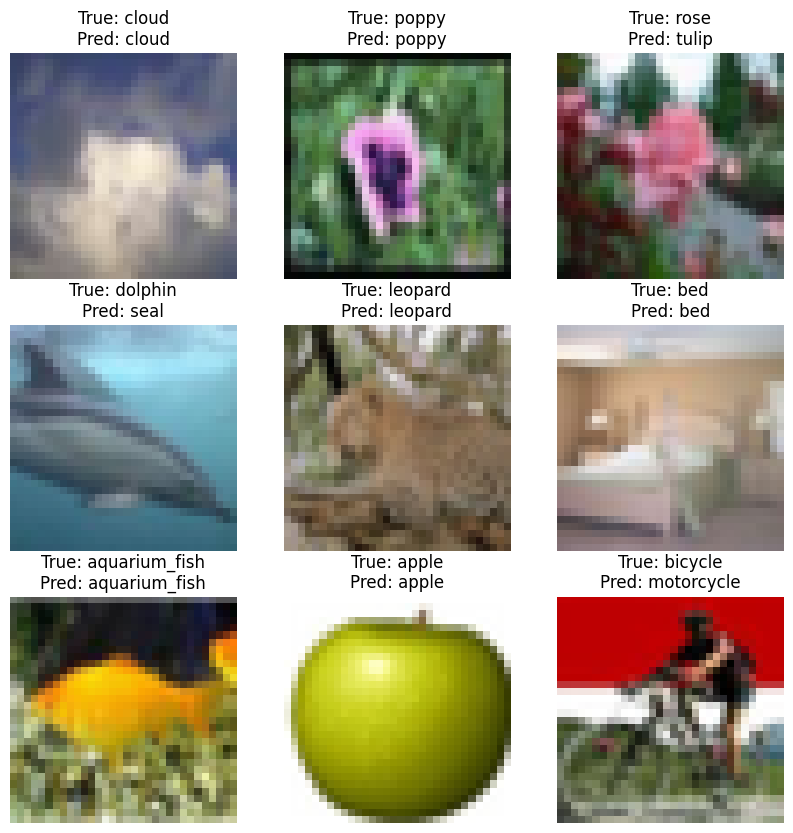

In [50]:
figure = plt.figure(figsize=(10,10))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    label_name = labels[label].decode('utf-8')
    pred_label = model.predict(img.unsqueeze(0).to(device))
    pred_label_name = labels[pred_label].decode('utf-8')
    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {label_name}\nPred: {pred_label_name}")
    plt.axis("off")
    plt.imshow(torch.einsum("c h w -> h w c", img))

plt.show()

In [57]:
print(f"Parameter count: {sum([param.nelement() for param in model.parameters()])}")

Parameter count: 13625956
